*Copyright (C) 2023 Intel Corporation*<br>
*SPDX-License-Identifier: BSD-3-Clause*<br>
*See: https://spdx.org/licenses/*

---

# Continually Learning Prototypes (CLP) on real data

# PW: "of real data" -> "on real data"

**Motivation**: This tutorial aims to demonstrate continual learning of the real data with our CLP algorithm. 

[Interactive continual learning for robots: a neuromorphic approach](https://dl.acm.org/doi/abs/10.1145/3546790.3546791 "Interactive continual learning for robots: a neuromorphic approach")

#### This tutorial assumes that you:
- have the [Lava framework installed](../../in_depth/tutorial01_installing_lava.ipynb "Tutorial on Installing Lava")
- are familiar with [Process interfaces in Lava](../../in_depth/tutorial02_processes.ipynb "Tutorial on Processes")
- are familiar with [ProcessModel implementations in Lava](../../in_depth/tutorial02_process_models.ipynb "Tutorial on ProcessModels")
- are familiar with how to [connect Lava Processes](../../in_depth/tutorial05_connect_processes.ipynb "Tutorial on connecting Processes")
- are familiar with how to [implement a custom learning rule](../../in_depth/tutorial08_stdp.ipynb "Tutorial on STDP")
- are familiar with how to [implement a reward-modulated learning rule](../../in_depth/three_factor_learning/tutorial01_Reward_Modulated_STDP.ipynb "Tutorial on R-STDP")
- are familiar with [intorductory tutorial on CLP](../../in_depth/clp/tutorial01_one-shot_learning_with_novelty_detection.ipynb "Tutorial on CLP")

Compared to the introductory CLP tutorial, we will use an upgraded version of the algorithm here. specifically, this version is concurrently capable of both unsupervised and supervised learning. We will perform both pure unsupervised learning via novelty-triggered one-shot learning and semi-supervised learning, where we enable the error signal from the user. The CLP will learn on the extracted features of a dataset (COIL-100), and we will compare unsupervised and semi-supervised learning results to offline K-NN performance. 

In [1]:
import numpy as np
import typing as ty
import matplotlib.pylab as plt
from lava.magma.core.learning.constants import GradedSpikeCfg

from lava.utils.weightutils import SignMode

from lava.magma.core.learning.learning_rule import Loihi3FLearningRule

from lava.magma.core.run_configs import Loihi2SimCfg
from lava.magma.core.run_conditions import RunSteps
from lava.proc.clp.prototype_lif.process import PrototypeLIF
from lava.proc.clp.novelty_detector.process import NoveltyDetector
from lava.proc.clp.nsm.process import Readout, Allocator
from lava.proc.io.source import RingBuffer, PySendModelFixed
from lava.proc.monitor.process import Monitor
from lava.proc.dense.process import Dense, LearningDense
from lava.proc.dense.models import PyLearningDenseModelBitApproximate

## Dasaset: COIL-100 

<center><img src="../../in_depth/clp/images/coil_100.png" style="width:80%"><center>
<center><figcaption align = "center"> Figure 1. COIL-100 dataset. The dataset includes 72 frames for each of the 100 objects rotated on a turntable. </figcaption><center>

## Data preparation and visualization

### Loading pre-extracted features

# PW: bold statement to call ResNet-9 a "small feature extractor". Why only 42 classes?
The following data file includes extracted features from 42 objects out of the original 100 objects from COIL-100 datasets. An in-house trained small feature extractor has extracted these features. Specifically, we have trained a ResNet-9 backbone on the COIL-100 dataset with a self-supervised learning paradigm called SimSiam. The exact details and optimization of the feature extractor are beyond the scope of this tutorial. Here we will focus on how to learn from these extracted features with CLP both in an unsupervised and supervised manner. 

In [2]:
# Load COIL-100 data (selected, well-separated 42 objects)
with open('coil100_features_separated_objs.npy', 'rb') as f:
    X = np.load(f)
    y = np.load(f)

# The label==0 is reserved for "no information" on communication channel
y = y + 1  

# Normalize the vectors
X = X / np.expand_dims(np.linalg.norm(X, axis=1), axis=1)
print(X.shape, y.shape)

(3024, 2048) (3024,)


Let's visualize a histogram of the similarities of a single random example to all the other samples. Note that we use dot product similarity in the Lava implementation of the CLP algorithm. Those samples from the same class will have high similarity, while the rest (majority) will have lower similarity. We can see that in the histogram below. This histogram also helps us roughly know which range of the similarity values (input currents to PrototypeLIF) we should sample with spike times to compete. 

# PW: not sure if I understand the plot. What are the different colors? Where do I see the intra-class and extra-class similarity?

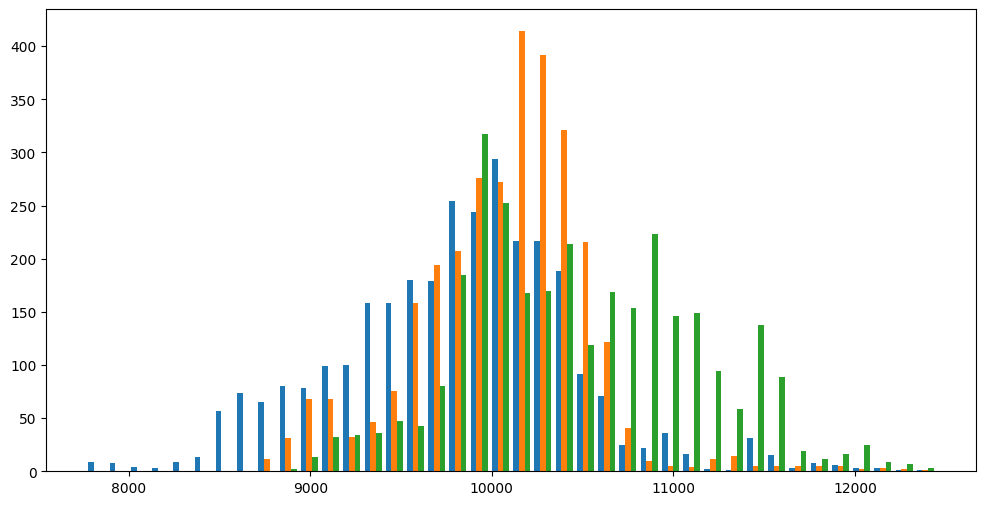

In [3]:
b_fraction = 7  # The fraction of the fixed point representation used to translate floating point input to graded spikes
X_fixed = np.floor(X * 2 ** b_fraction).astype(np.int32)
sim_single = np.dot(X_fixed[np.random.randint(low=0, high=42*72, size=3),:], X_fixed.T)
plt.figure(figsize=(12,6))
plt.hist(sim_single.T, bins=40)
plt.show()

### Train-test split
There are 72 frames for each object. Let's go ahead and decide how many samples per class we want to provide for training. 

In [4]:
from sklearn.model_selection import train_test_split
n_train_per_class = 3
X_train, X_test, y_train, y_test = train_test_split(X_fixed, y, test_size=(72-n_train_per_class)/72, random_state=42, stratify=y)

### Ordering of the data
Next, we will order the training and testing samples by the objects. This way we simulate online sequential learning. Note that this data order is non-i.i.d, as there is no shuffling.  

In [5]:
X_train = X_train[np.argsort(y_train),:]
y_train = y_train[np.argsort(y_train)]

### Sub-sampling the data
If we wish, we can subsample the test set of each object class by the factor ```k_sample```, as the consecutive image frames are very similar.

In [6]:
k_sample = 3
X_test = X_test[np.argsort(y_test),:][::k_sample, :]
y_test = y_test[np.argsort(y_test)][::k_sample]


Additionally, we can choose how many objects we want to learn out of 42 objects available in the subset of the original dataset that we are providing here in terms of extracted feature vectors. 

In [7]:
n_classes = 20

X_train = X_train[y_train<=n_classes, :]
X_test = X_test[y_test<=n_classes, :]
y_train = y_train[y_train<=n_classes]
y_test = y_test[y_test<=n_classes]

print(X_train.shape)
print(X_test.shape)

(60, 2048)
(460, 2048)


### Visualization of the similarity between the training and testing samples

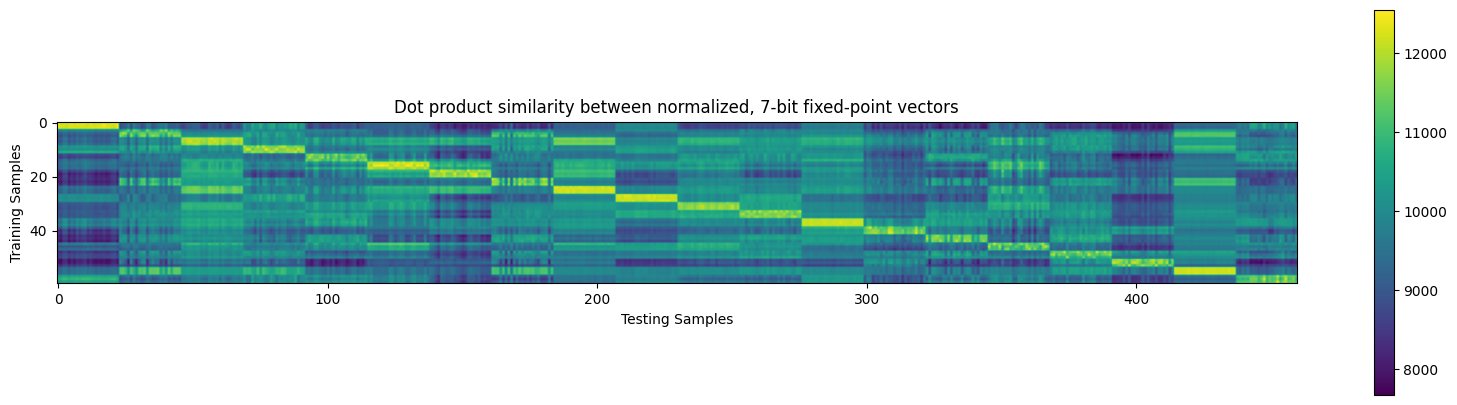

In [8]:
sims = np.dot(X_train, X_test.T)
plt.figure(figsize=(20,5))
plt.imshow(sims)
plt.colorbar()
plt.title("Dot product similarity between normalized, 7-bit fixed-point vectors")
plt.xlabel("Testing Samples")
plt.ylabel("Training Samples")
plt.show()

## Temporal WTA 

#### (Optional) Hyperparameter search for PrototypeLIF

# PW: WTA = Winner-takes-all? Please describe. Maybe you should move the CLP network diagram above the hyperparameter tuning, and describe how it works. Or at least how it changed from the CLP network on the other tutorial. I.e. what the role of the WTA is
# PW: Why is there commented code below?

In [9]:
# from utils import wta_hyperparam_search
# a_in = np.array([10500, 11000, 11300, 11600, 11900, 12200])
# n_steps = 35
# best_params = wta_hyperparam_search(a_in, n_steps)

#### Visualize voltage dynamics

# PW: Why?
Let's also visualize the voltage dynamics with the chosen hyperparameters for the input values we wanted to distinguish in the temporal domain
<center><img src="../../in_depth/clp/images/wta_voltage.png" style="width:50%"><center>
<center><figcaption align = "center"> Figure 1. Voltage dynamics for different values of input current </figcaption><center>

## Setup the CLP network

# PW: This needs description. See comment above
### Lava diagram of CLP for COIL-100 experiment

<center><img src="../../in_depth/clp/images/clp_coil100_lava_diagram.png" style="width:90%"><center>
<center><figcaption align = "center"> Figure 1. Lava process diagram of the CLP that is capable of both unsupervised and supervised learning </figcaption><center>

### Parameterization of CLP

In [10]:
# General params
n_features = X_train.shape[1]
t_wait = 14  # the waiting window for novelty detection after input injection
n_protos = 80  # number of the prototypes
# The time difference between two consecutive inputs
n_steps_per_sample = 35

# PrototypeLIF neural dynamics parameters
du = 50
dv = 700
vth = 52000



### Initialize the CLP network
We initialize the CLP object with the global and process-specific parameters. Specifically, ```supervised``` is a flag to signal the system if it should allocate new prototypes based on both the novelty detection and the supervision signal of the user (semi-supervised) or based solely on the novelty detection (unsupervised). ```n_protos``` is the number of the prototypes, ```n_features``` is the length of the input feature vector, ```n_steps_per_sample``` is the number of steps needed to process each input sample, ```b_fraction``` is the number of the bits for fixed representation of the input. In addition, ```du```, ```dv```, ```vth``` are ```PrototypeLIF``` parameters that are taken from the above WTA hyperparameter optimization, while ```t_wait``` is the ```NoveltyDetector``` parameter that specifies the number of time steps to wait for a PrototypeLIF before declaring the input pattern a novel one. 

Using ```generate_input_spikes()``` function we setup input spikes for the whole run: both input pattern spikes and label input spikes. ```setup_procs_and_conns()``` function initialize all the necessary processes of the CLP and connects them.

In [11]:
from clp import CLP

clp = CLP(supervised=False,
          n_protos=n_protos,
          n_features=n_features,
          n_steps_per_sample=n_steps_per_sample,
          b_fraction=b_fraction,
          du=du,
          dv=dv,
          vth=vth,
          t_wait=t_wait)

s_pattern_inp, s_user_label = clp.generate_input_spikes(X_train, X_test, y_train)
clp = clp.setup_procs_and_conns(s_pattern_inp, s_user_label)

prototypes = clp.prototypes
num_steps = clp.num_steps

## Unsupervised learning experiment

Here we will perform pure unsupervised learning via novelty-triggered one-shot learning similar to [intorductory tutorial on CLP](../../in_depth/clp/tutorial01_one-shot_learning_with_novelty_detection.ipynb "Tutorial on CLP")

# PW: I tried to run this and it takes long. Maybe the whole notebook should rather be a tech demo instead of a tutorial.

In [12]:
# Run
exception_map = {
        LearningDense: PyLearningDenseModelBitApproximate
}
run_cond = RunSteps(num_steps=num_steps)
run_cfg = Loihi2SimCfg(select_tag="fixed_pt",
                       exception_proc_model_map=exception_map)

prototypes.run(condition=run_cond, run_cfg=run_cfg)

novelty_spikes, proto_spikes, error_spikes, preds = clp.get_results()

# Stop the run
prototypes.stop()


### Visualization of the results

#### Spike raster plot for the neurons of interest

# PW: The upper panel is very nice. But the lower one doesn't work anymore with that amount of classes. Very hard to see what's happening.

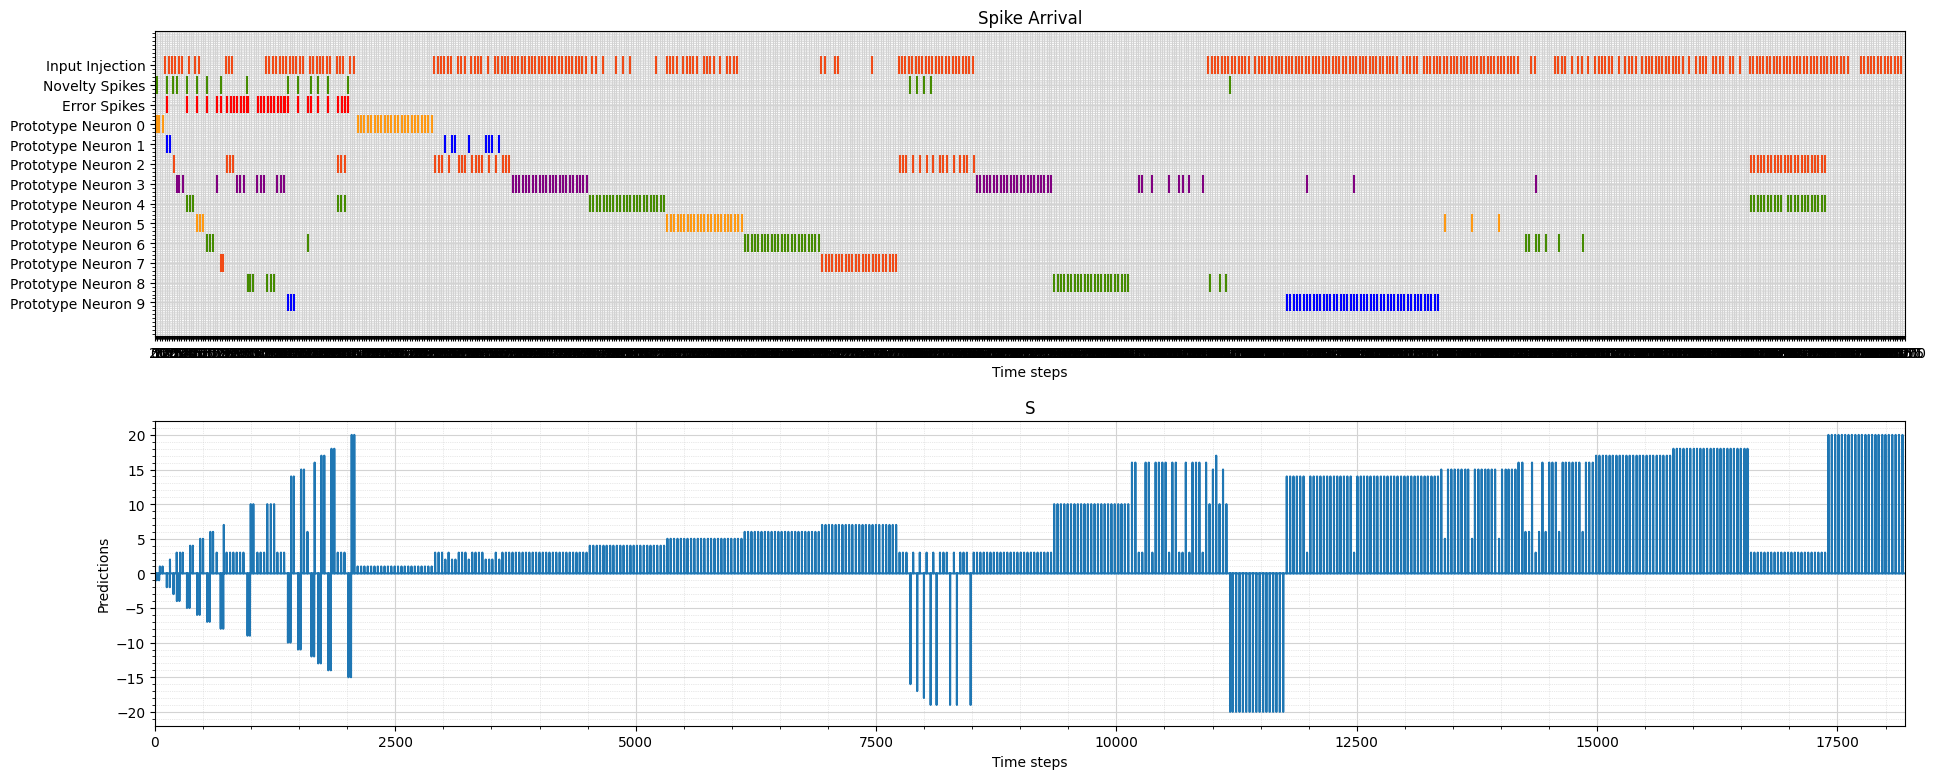

In [13]:
from utils import  plot_spikes, plot_spikes_time_series
time = np.arange(num_steps)
plot_spikes_time_series(
        spikes=[np.where(proto_spikes[:, 9])[0],
                np.where(proto_spikes[:, 8])[0],
                np.where(proto_spikes[:, 7])[0],
                np.where(proto_spikes[:, 6])[0],
                np.where(proto_spikes[:, 5])[0],
                np.where(proto_spikes[:, 4])[0],
                np.where(proto_spikes[:, 3])[0],
                np.where(proto_spikes[:, 2])[0],
                np.where(proto_spikes[:, 1])[0],
                np.where(proto_spikes[:, 0])[0],
                np.where(error_spikes)[0],
                np.where(novelty_spikes)[0],
                np.where(s_pattern_inp[0, :])[0]],
        time_series=preds,
        y_label_time_series = 'Predictions',
        time=time,
        figsize=(20, 8),
        legend=['Prototype Neuron 9', 'Prototype Neuron 8',
                'Prototype Neuron 7', 'Prototype Neuron 6',
                'Prototype Neuron 5', 'Prototype Neuron 4',
                'Prototype Neuron 3', 'Prototype Neuron 2',
                'Prototype Neuron 1', 'Prototype Neuron 0', 
                'Error Spikes', 'Novelty Spikes', 'Input Injection'],
        colors=['blue', '#458b00', '#f14a16', '#458b00', '#ff9912', '#458b00', 'purple', '#f14a16', 'blue', '#ff9912','r','#458b00', '#f14a16', '#458b00'],
        title='Spike Raster Plot',
        num_steps=num_steps
)

#### Extract prediction based on the output of the CLP

In [14]:
n_train_samples = X_train.shape[0]
y_pred = np.maximum.reduceat(preds.copy(), np.r_[0:len(preds):n_steps_per_sample])[n_train_samples:]

#### Confusion matrix for 20 objects

Accuracy:  0.6456521739130435


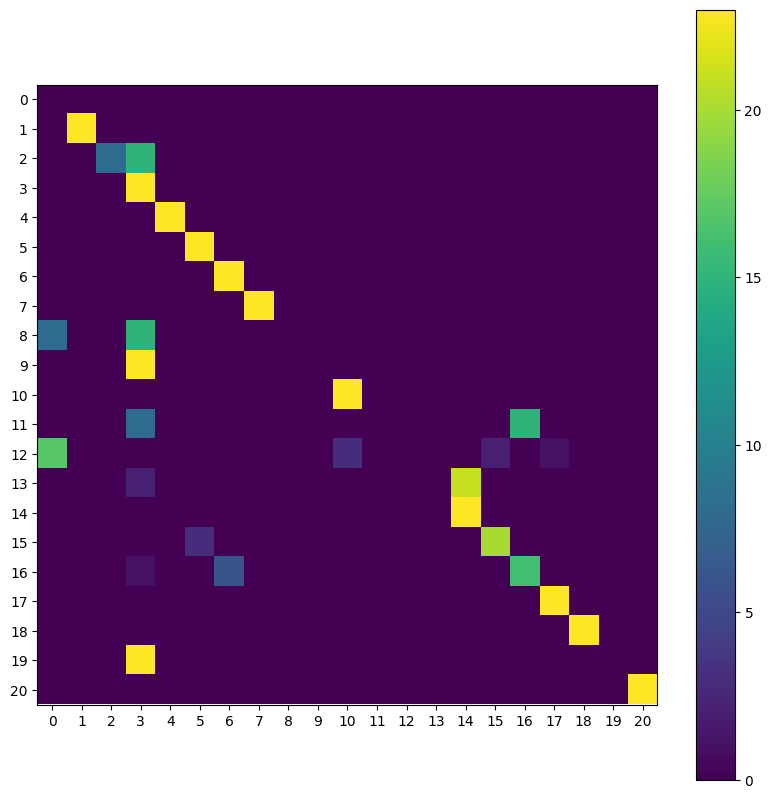

In [15]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_test, y_pred)
print("Accuracy: ", acc)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,10))
plt.xticks(np.arange(n_classes+1))
plt.yticks(np.arange(n_classes+1))
plt.imshow(cm)
plt.colorbar()
plt.show()

## Offline Supervised Baselines: K-NN accuracy

# PW: maybe move the baseline section up before the results for unsupervised learning.
# PW: Why is kNN with k=1 a good baseline? What about other supervised learning methods (i.e. a feed-forward NN)? Are there no other models in the literature you can compare the performance to? (I tried with k>1 and interestingly the performance of kNN reduced. Why?)
The offline K-NN (k=1) accuracy is 97.6%

In [35]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
# y_pred = knn.predict(X_test.T)
# acc = accuracy_score(y_test.T, y_pred.T)
# print(acc)

ValueError: Found input variables with inconsistent numbers of samples: [2048, 60]

In [36]:
y_train.shape

(60,)

## Semi-supervised interactive learning

In the semi-supervised learning experiment, we enable the error signal from the user. As a result, when the predicted label does not match with the true label, an error signal is generated to trigger the allocation of a new prototype.

### Setup CLP with supervision

In [17]:
from clp import CLP

clp = CLP(supervised=True,
          n_protos=n_protos,
          n_features=n_features,
          n_steps_per_sample=n_steps_per_sample,
          b_fraction=b_fraction,
          du=du,
          dv=dv,
          vth=vth,
          t_wait=t_wait)

s_pattern_inp, s_user_label = clp.generate_input_spikes(X_train, X_test, y_train)
clp = clp.setup_procs_and_conns(s_pattern_inp, s_user_label)

prototypes = clp.prototypes
num_steps = clp.num_steps

In [18]:
# Run
exception_map = {
        LearningDense: PyLearningDenseModelBitApproximate
}
run_cond = RunSteps(num_steps=num_steps)
run_cfg = Loihi2SimCfg(select_tag="fixed_pt",
                       exception_proc_model_map=exception_map)

prototypes.run(condition=run_cond, run_cfg=run_cfg)

novelty_spikes, proto_spikes, error_spikes, preds = clp.get_results()

# Stop the run
prototypes.stop()


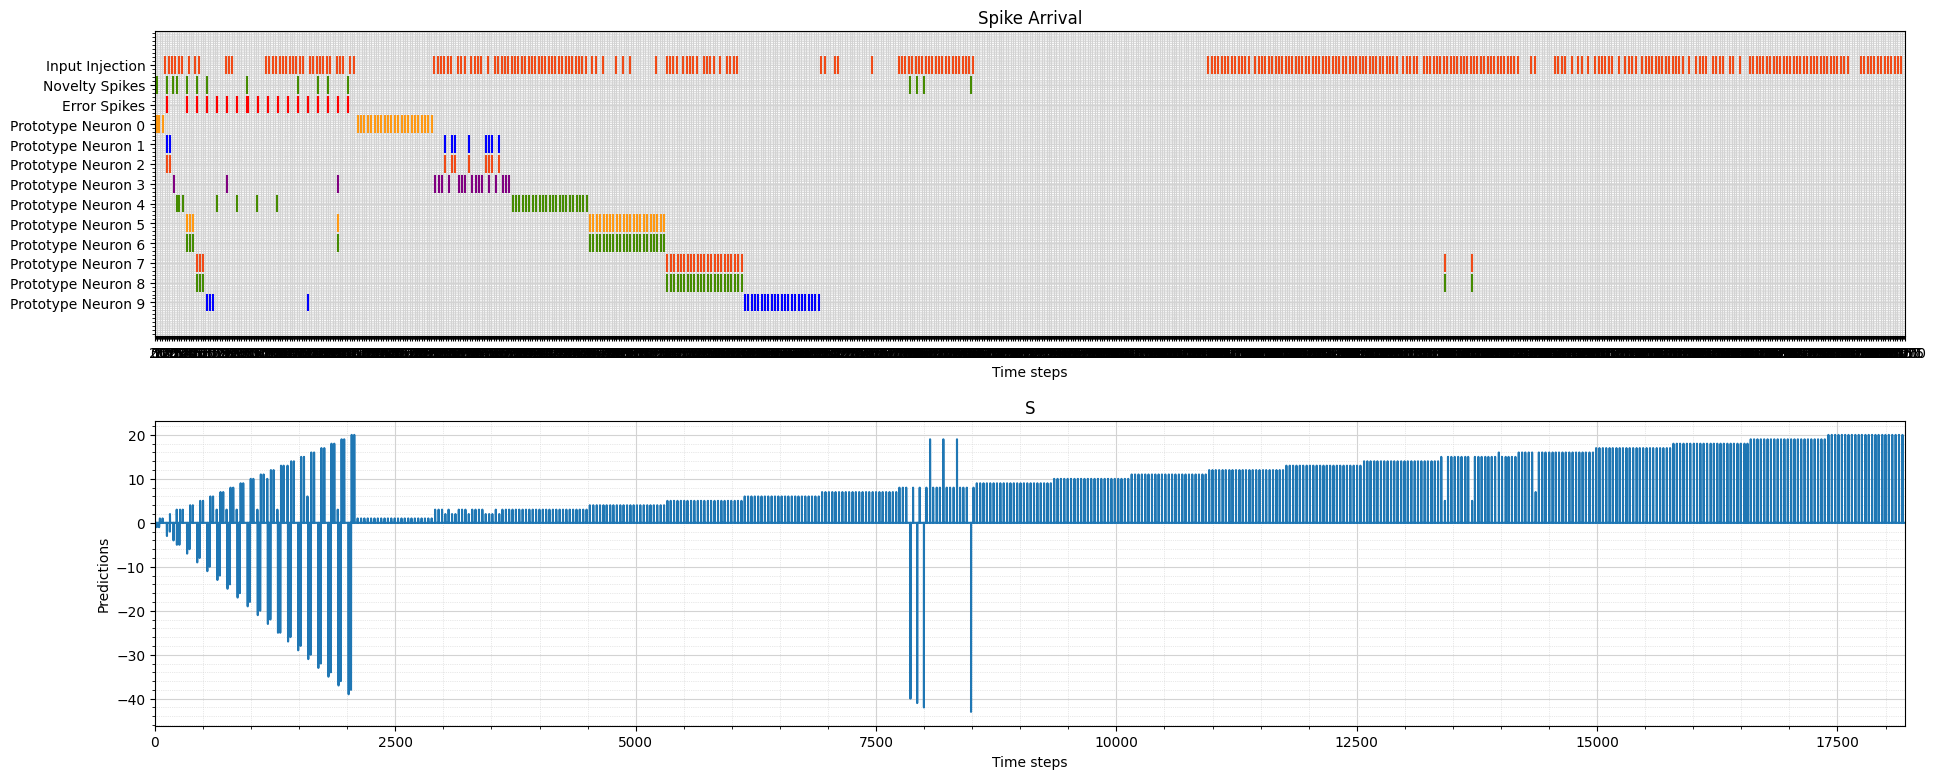

In [19]:
from utils import  plot_spikes, plot_spikes_time_series
time = np.arange(num_steps)
plot_spikes_time_series(
        spikes=[np.where(proto_spikes[:, 9])[0],
                np.where(proto_spikes[:, 8])[0],
                np.where(proto_spikes[:, 7])[0],
                np.where(proto_spikes[:, 6])[0],
                np.where(proto_spikes[:, 5])[0],
                np.where(proto_spikes[:, 4])[0],
                np.where(proto_spikes[:, 3])[0],
                np.where(proto_spikes[:, 2])[0],
                np.where(proto_spikes[:, 1])[0],
                np.where(proto_spikes[:, 0])[0],
                np.where(error_spikes)[0],
                np.where(novelty_spikes)[0],
                np.where(s_pattern_inp[0, :])[0]],
        time_series=preds,
        y_label_time_series = 'Predictions',
        time=time,
        figsize=(20, 8),
        legend=['Prototype Neuron 9', 'Prototype Neuron 8',
                'Prototype Neuron 7', 'Prototype Neuron 6',
                'Prototype Neuron 5', 'Prototype Neuron 4',
                'Prototype Neuron 3', 'Prototype Neuron 2',
                'Prototype Neuron 1', 'Prototype Neuron 0', 
                'Error Spikes', 'Novelty Spikes', 'Input Injection'],
        colors=['blue', '#458b00', '#f14a16', '#458b00', '#ff9912', '#458b00', 'purple', '#f14a16', 'blue', '#ff9912','r','#458b00', '#f14a16', '#458b00'],
        title='Spike Raster Plot',
        num_steps=num_steps
)

In [20]:
n_train_samples = X_train.shape[0]
y_pred = np.maximum.reduceat(preds.copy(), np.r_[0:len(preds):n_steps_per_sample])[n_train_samples:]

### Performance comparison to the unsupervised and K-NN results

Below we calculate the accuracy of the test set after the semi-supervised learning is finished. As expected, the results are much better than unsupervised learning and very near to offline K-NN results.

Accuracy:  0.9434782608695652


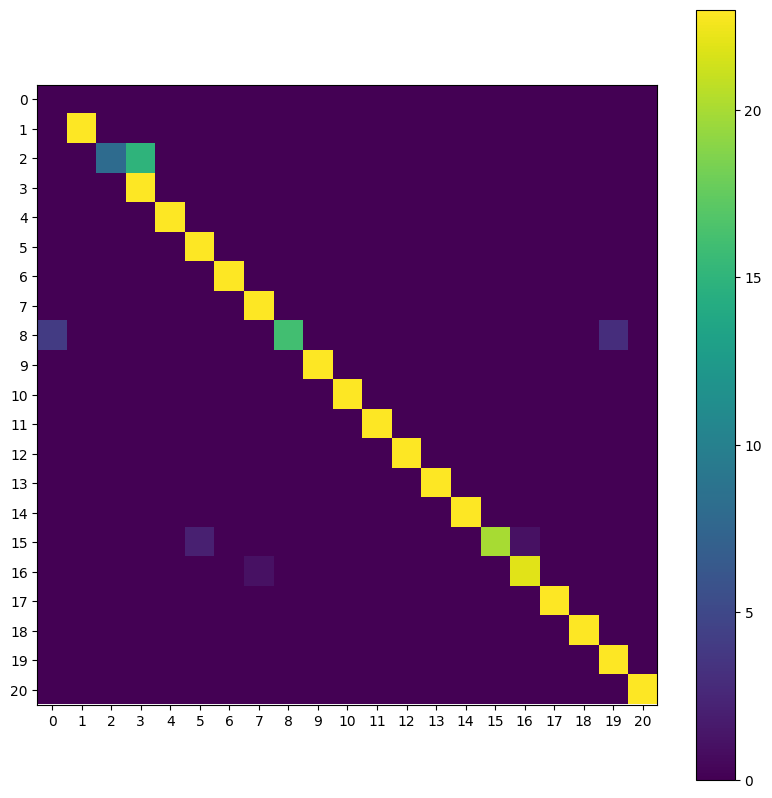

In [21]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_test, y_pred)
print("Accuracy: ", acc)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,10))
plt.xticks(np.arange(n_classes+1))
plt.yticks(np.arange(n_classes+1))
plt.imshow(cm)
plt.colorbar()
plt.show()